### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 
### Radmehr Ghassabtabarshiadeh

Part A

A/B testing to test the null hypothesis "there is no signifacnt difference between the two traders" and the alternative hypothesis of there being a signifacnt difference between the two traders, with the significance value (alpha) set to 0.05. A market session will run with the specification mentioned on the brief with start time and end time are set to 0 and 1 hours respectively with order interval of 60 seconds throuout parts A-C. This was chosen so sufficient data collection and trades take place after sessions. After the simulation are complete the accumilated average profit of each trader type is taken. This process is repeated for n number of sessions. To test the hypothesis, first normality of the data is measured and either a parametric or a non-parametric test is performed. The collected averages, are passed in to Shapiro-Wilk test to understand their distribution, then either t-test or Mann-Whitney-U test are utilised as the parametric and non-parametric test respectively.

In [1]:
from helper import *
import numpy as np

supply_range = (310, 310)
demand_range = (250, 490)
start_time = 0
end_time = 60*60

In [26]:
n500mean_shvr, n500mean_zic = run_market_sim(trial_id="n500", no_sessions=500, R=50, n=20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time, path='n500_avg_balance.csv')
n50mean_shvr, n50mean_zic = run_market_sim(trial_id="n50", no_sessions=50, R=50, n=20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time, path='n50_avg_balance.csv')

(248, 252) number of times traders had more profit than the other: (shvr, zic)
(24, 26) number of times traders had more profit than the other: (shvr, zic)


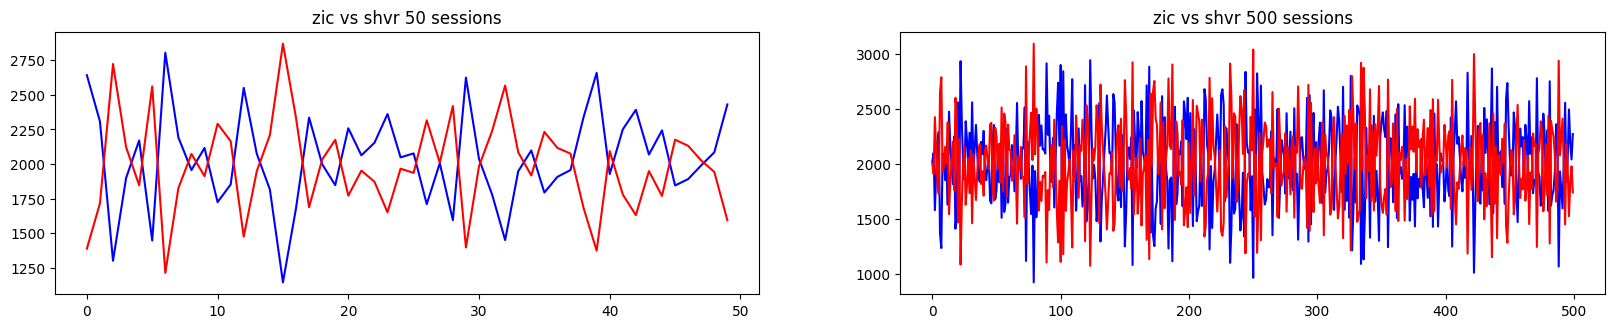

In [34]:
plot_performance(n50mean_zic, n500mean_zic, n50mean_shvr, n500mean_shvr)
print(compare(n500mean_shvr, n500mean_zic), "number of times traders had more profit than the other: (shvr, zic)")
print(compare(n50mean_shvr, n50mean_zic), "number of times traders had more profit than the other: (shvr, zic)")

The plots above showcase what was the average profit a trader made at the end of a session, zic traders being blue and shvr traders being red. It is observed that the profitablity is shared roughly equally between the two traders. So the expected results from the statistical test would be to conclude that we do not have sufficient evidence to reject the null hypothesis. That mean, there is no significant difference between the two traders when it comes to average profit in the market.

In [35]:
_, pvalue50_shvr = stats.shapiro(n500mean_shvr)
_, pvalue500_shvr = stats.shapiro(n50mean_shvr)
_, pvalue500_zic = stats.shapiro(n500mean_zic)
_, pvalue50_zic = stats.shapiro(n50mean_zic)
print(pvalue50_shvr, pvalue500_zic, pvalue50_zic, pvalue500_shvr)

0.38963526487350464 0.37040531635284424 0.7784656286239624 0.7998491525650024


Since the market is populated with similar ratios of buyers and sellers of each type, the variance of the two trader's profits is also roughly similar. Shapiro-Wilk test is utilised to understand the distribution of each data, if they are following a normal distribution a parametric test is used, otherwise a non-parametric test is utilised. As the output n=50 is not following a normall distribution therefore a non-parametric test such as Mann-Whitney-U test will be applied, and for n=500, dataset is following a normal distribution therefore, a t-test can be used.

In [37]:
_, p_val50 = stats.mannwhitneyu(n50mean_zic, n50mean_shvr)
print(p_val50, 'p val for 50 sessions')
_, p_val500 = stats.ttest_ind(n500mean_zic, n500mean_shvr)
print(p_val500, 'p val for 500 sessions')

0.4100452817469036 p val for 50 sessions
0.9907804259631603 p val for 500 sessions


In the simulated market sessions, the p value for both sessions, is above the threshold of 0.05, meaning we do not have sufficient evidence to reject the null hypothesis. In other words, we can conclude that there is no significant difference between the two trader's performance when comparing the average profit per session.

PART B

Code cell below, modifies the previously used code to accomedate changes to ratios by collecting and returning their average profit at the end of each session in a pair. For each pair of data, 9 in this case, they will be tested to see whether they are normaly distributed using Shapiro-Wilk and then appropriate hypothesis testing is applied. Another thing to consider is the variance of the data, since there are different number of traders in the market, the variance difference will be high so Welch's t-test is utilised here when data is parametric.

In [18]:
R = [10, 20, 30, 40, 50, 60, 70, 80, 90]

res50 = R_market_run(R, 50, 20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time) #9 arr corresponding to each ratio, res[n][0]=shvr, [n][1]=zic each 50 long                                                                                                             #res[n][0] = shvr, res[n][1] = zic
res500 = R_market_run(R, 500, 20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time) #same as above but 500 long

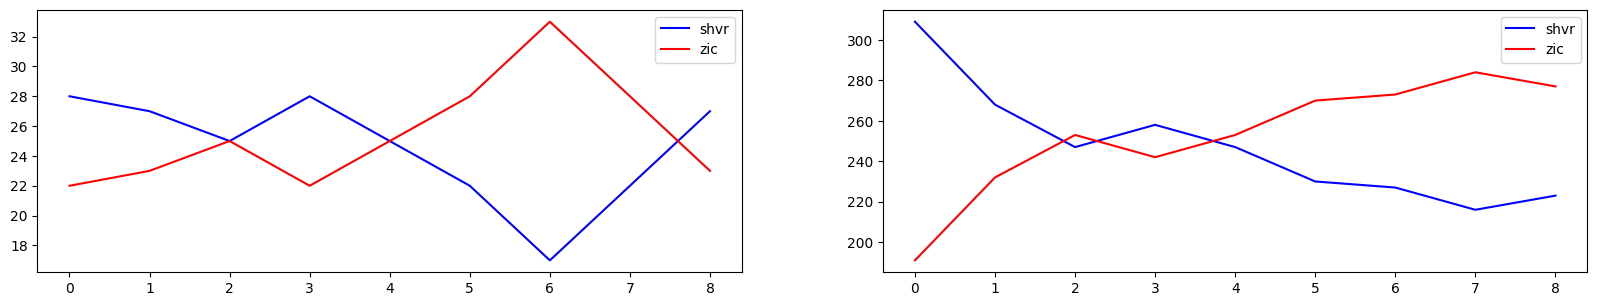

In [56]:
plot_wins(res50, res500)

To visualise the results of the market sessions, the number of "wins" a trader has over the other is plotted against all ratios from 1 to 9. The "number of wins" means the number of time the average profit of a the trader was higher than the other trader during the n sessions with a given ratio (at 0 for every 1 shvr trader there are 9 zic traders). The data suggest that shaver traders perform very well when there are less of them in the market and as the number of ZIC traders grow, ZIC starts to be the more profitable trader on average.

In [41]:
p_vals_50 = collect_pvals_norm(res50)
p_vals_500 = collect_pvals_norm(res500)

p_res50 = A_B_test(p_vals_50, res50)
p_res500 = A_B_test(p_vals_500, res500)

n=50, ratio: 1 to 9 is NOT normal used NON-parametric test, p val is: 0.4120
n=50, ratio: 2 to 8 is NORMAL used parametric test, p val is: 0.4918
n=50, ratio: 3 to 7 is NORMAL used parametric test, p val is: 0.5277
n=50, ratio: 4 to 6 is NORMAL used parametric test, p val is: 0.0118
n=50, ratio: 5 to 5 is NORMAL used parametric test, p val is: 0.8209
n=50, ratio: 6 to 4 is NORMAL used parametric test, p val is: 0.0192
n=50, ratio: 7 to 3 is NORMAL used parametric test, p val is: 0.0122
n=50, ratio: 8 to 2 is NORMAL used parametric test, p val is: 0.2910
n=50, ratio: 9 to 1 is NORMAL used parametric test, p val is: 0.4769
n=500, ratio: 1 to 9 is NOT normal used NON-parametric test, p val is: 0.0000
n=500, ratio: 2 to 8 is NOT normal used NON-parametric test, p val is: 0.0020
n=500, ratio: 3 to 7 is NORMAL used parametric test, p val is: 0.4800
n=500, ratio: 4 to 6 is NORMAL used parametric test, p val is: 0.2887
n=500, ratio: 5 to 5 is NORMAL used parametric test, p val is: 0.6192
n=500

When n=50, there is simply not enough data to conclude any evidence from the p values generated as it can vary dramatically with each run. In the simulation above, no consistant logic or pattern can be extracted from the output as mostly it suggest no significance except for one or two instances due to the differences being small. However as the number of sessions are increased, for the ratios where there is less shavers in the market, the difference becomes significant to favour them. As the ratios get to the extreme ends of all of the market being shavers, the few zic traders in the market start giving higher average profit. Finally for the case of equal ratios, there is no difference between the two traders as observed before. In conclusion, Shavers perform best in a market dominated by zic traders and as the number of shavers increase, zic traders perform better.

PART C

Four trader types with different populations being tested to see whcich is the best. Having 'GVWY', 'SHVR', 'ZIC' and 'ZIP' traders at a predefined ratios below. Note that to gather all permutations, np.roll is used. P values obtained are using either Annova test or kruskal test depending on whether data is parametric or non-parametric, all means collected bein normal is very unlikely, therefore only the non-parametric test (kruksal) is expected to be used. Here rejecting the null hypothesis means there is a significant difference in the market but does not determine which trader is the best. Having a p value lower than 0.05 is expected in all sessions, and furthur analysis is needed to determine the best trader. Here a total of 100 independant sessions are ran on each ratio to obtain enough data for analysis and to allow the zip trader to adjust its hyper parameters better. 

In [2]:
t = [25, 25, 25, 25]
t1 = [40, 20, 20, 20]
t2 = [10, 30, 30, 30]
t3 = [70, 10, 10, 10]

four_25_100_sess, pval_25_n100 = run_market_sim_four("equal_500", 100, t, 20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time)

#res[i] = [mean[shvr], mean[gvwy], mean[zic], mean[zip]], each mean either 50 or 500 long where i is the permutation
res_40100, pvals40100 = [0] * 4, []
res_10_100, pvals10100= [0] * 4, []
res_70_100, pvals70100 = [0] * 4, []
for i in range(len(t)):

    forty_100, p40100 = run_market_sim_four(trial_id="40_"+str(i)+"_perm_500", no_sessions=100, t=np.roll(t1, i), n=20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time)
    res_40100[i] = forty_100
    pvals40100.append(p40100)

    ten_100, p10100 = run_market_sim_four(trial_id="10_"+str(i)+"_perm_500", no_sessions=100, t=np.roll(t1, i), n=20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time)
    res_10_100[i] = ten_100
    pvals10100.append(p10100)

    seventy_100, p70100 = run_market_sim_four(trial_id="70_"+str(i)+"_perm_500", no_sessions=100, t=np.roll(t1, i), n=20, supply_range=supply_range, demand_range=demand_range, start_time=start_time, end_time=end_time)
    res_70_100[i] = seventy_100
    pvals70100.append(p70100)

In [3]:
print(pvals70100)
print(pval_25_n100)
print(pvals10100)
print(pvals40100)

[6.503205231878128e-26, 6.285072222433908e-39, 9.899168203870766e-15, 1.8239030135286042e-48]
6.353342094290095e-41
[1.791183010018632e-25, 5.803980173258521e-40, 3.9793407810632255e-15, 8.493893005327505e-42]
[1.2747508406824103e-29, 3.715662837182175e-45, 4.1865327141858616e-11, 2.5887012185409904e-37]


The p values collected are mostly all below the threshold of 0.05 leading to rejecting the null hypothesis and concluding that there is a significant difference between the traders. This was the expected output as the different ratios and nature of the traders will lead to such p values.

Plots below, visualise the data for better understanding trader's performance. For inbalances, the number of wins is plotted for each trader and for the same ratio average profit per session is also plotted. As previously observed, shaver performs very well when there are less of them in the market but as the number of the zic traders increase, they become the better performing trader. Zip trader is the worst performer in the market, but ther seem to be a trend where there is less of them, they start to perform better and better optimise their hyperparameters as shown by the [10,30,30,30] permutation graph. In conclusion, zic or shavers perform best on the simulated markets depending on their ratios. ZIP traders need more time and lesser numbers of them to start improving and trading better. Changing the end time to something longer than a day might improve their performance a lot more.

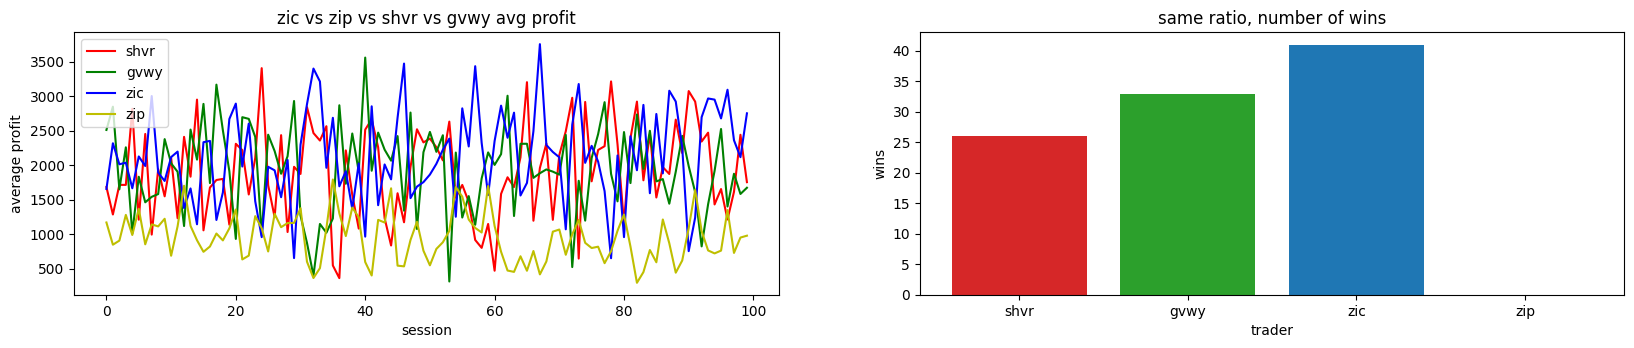

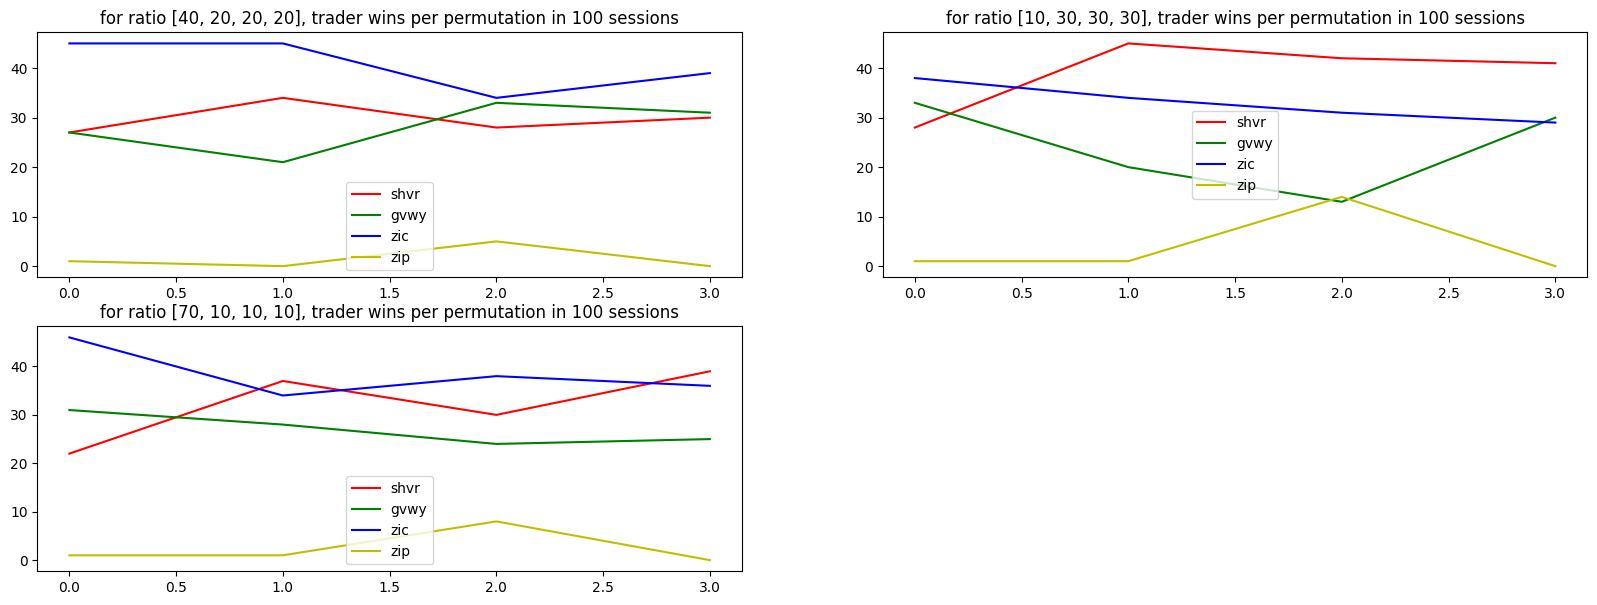

In [4]:
plot_performance_same_ratio(four_25_100_sess)
plot_wins_4(res_40100, t1, res_10_100, t2, res_70_100, t3)

PART D.1:

To replicate the experiment, a single zipsh trader is in the market with 20 other zic traders, where the zipsh is a buyer. Goal is to evaluate zipsh's performance and monitor its improvement over each day. 30 independant runs are done to collect a normalized average profit per second for the zipsh trader, then it is ploted per session to understand whether there is an improvement or not. Here k is set to 4, optimizer is 'ZIPSH' for its stochastic hill climber and a single session lasts 30 days and the evaluation stage remains untouched. The order intervals are set to 30 seconds, supply and demand curves are the same as the parts before.

In [7]:
#30 sessions, start=0 end= 60*60*24*30 (30 days)
#hyper = [[b, m, ca, cr, mb]], index == day
n = 30
start_time=0
end_time=60*60*24*30
supply=(310, 310)
buy=(250, 490)
buyer_spec = [('ZIPSH', 1, {'k': 4, 'optimizer': 'ZIPSH'}), ('ZIC', 10)]
seller_spec = [('ZIC', 10)]
zipsh_profit, zic_profit, total_avg_profit_perS, hyper_params = run_market_sim_D("replicate", n, supply, buy, start_time, end_time, "replicate_avg_balance.csv", "replicate_strats.csv", buyer_spec, seller_spec)
betas = hyper_params[0]
momentums = hyper_params[1]
c_a = hyper_params[2]
c_r = hyper_params[3]
initial_margin = hyper_params[4]

In [ ]:
#30 sessions, start=0 end= 60*60*24*30 (30 days)
#hyper = [[b, m, ca, cr, mb]], index == day
n = 3
start_time=0
end_time=60*60*24*30
supply=(50, 75)
buy=(125, 150)
buyer_spec = [('ZIPSH', 1, {'k': 4, 'optimizer': 'ZIPSH'}), ('ZIC', 10)]
seller_spec = [('ZIC', 10)]
zipsh_profit, zic_profit, total_avg_profit_perS, hyper_params = run_market_sim_D("replicate", n, supply, buy, start_time, end_time, "replicate_avg_balance.csv", "replicate_strats.csv", buyer_spec, seller_spec)
betas = hyper_params[0]
momentums = hyper_params[1]
c_a = hyper_params[2]
c_r = hyper_params[3]
initial_margin = hyper_params[4]

In [14]:
print(total_avg_profit_perS)

[[0.9570473056174711, 0.9893332016202633, 1.0088843451720564, 1.0166278271115015, 1.0188081175174664, 1.0247723117231635, 1.0529109068067837, 1.006240329234119, 1.0605833983464292, 1.0371482184804435, 1.0392264368955308, 1.0600120327379698, 1.0076351832028927, 1.0152373681916718, 1.063542957420655, 0.9556117271756973, 1.0572385871541545, 1.0324591064349788, 1.0432479314183998, 0.9896139206336046, 1.01749936506052, 1.0724415274547254, 1.035447581319417, 1.0431483544256008, 1.0537364644665628, 1.021125871254791, 1.0419833817708108, 1.0529104185200622, 1.0249664498842304, 1.0202339683215524]]


The independant runs show that the single zipsh trader is indeed making a profit and improving itself in the market and returning a higher profit from the starting point. The results show that the rate momentum changes is inversly proportional to the profit zipsh is making. This can be due to having unstable updates, or overshooting the optimal solution leading to a dramatic decrease in the profit. Whenever there is a steady increase in the beta value without a dramatic increase of the momentum, the trader reaches an optimal improvement stage as shown by the figures below (first few are plotted).

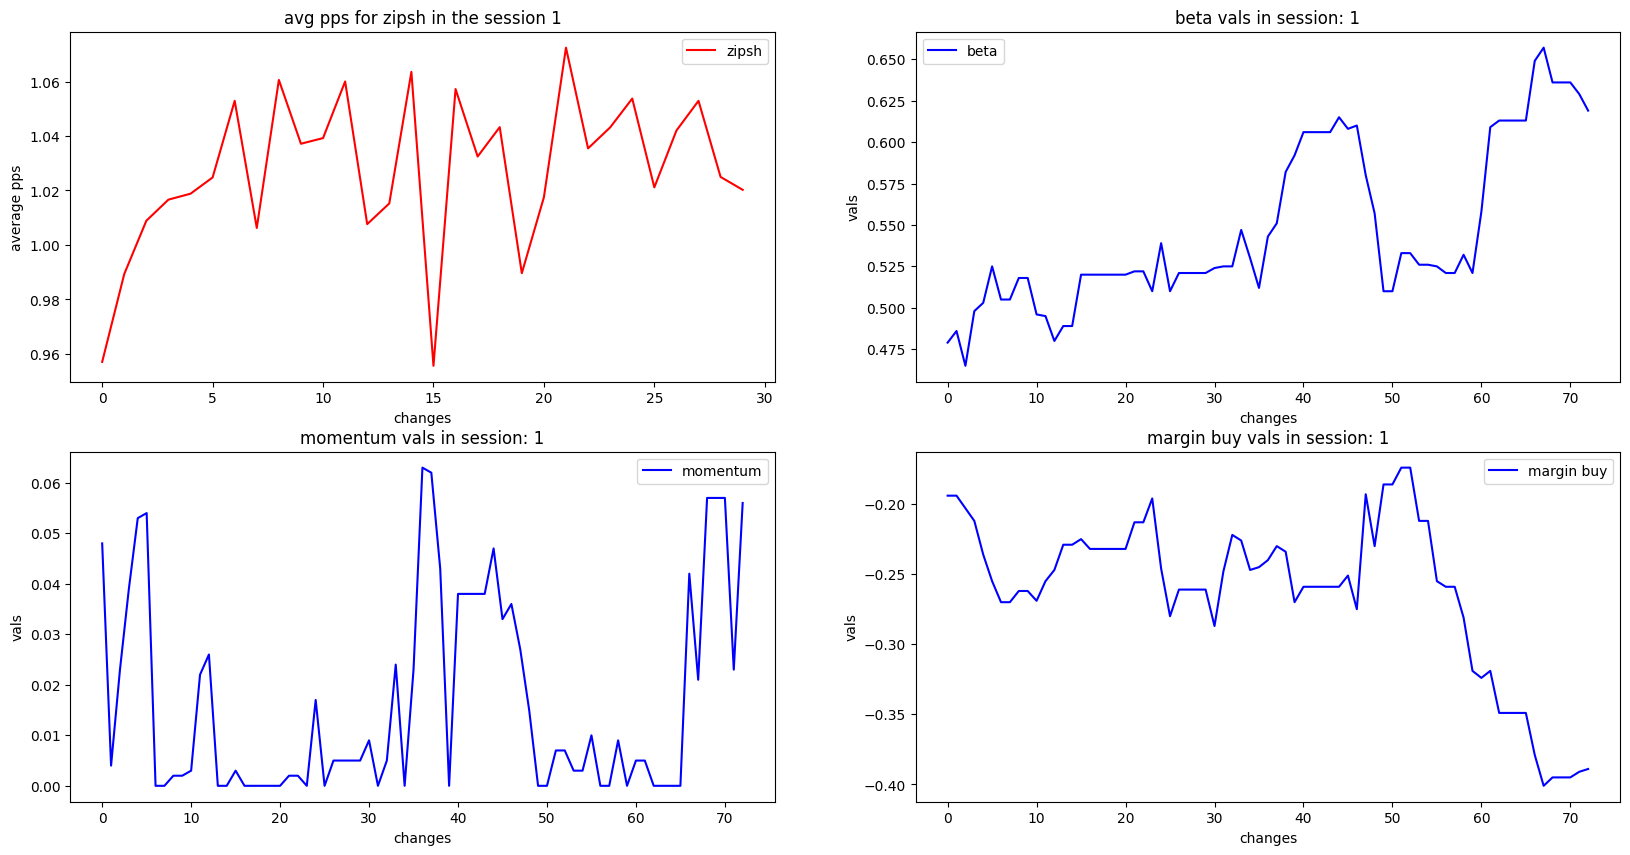

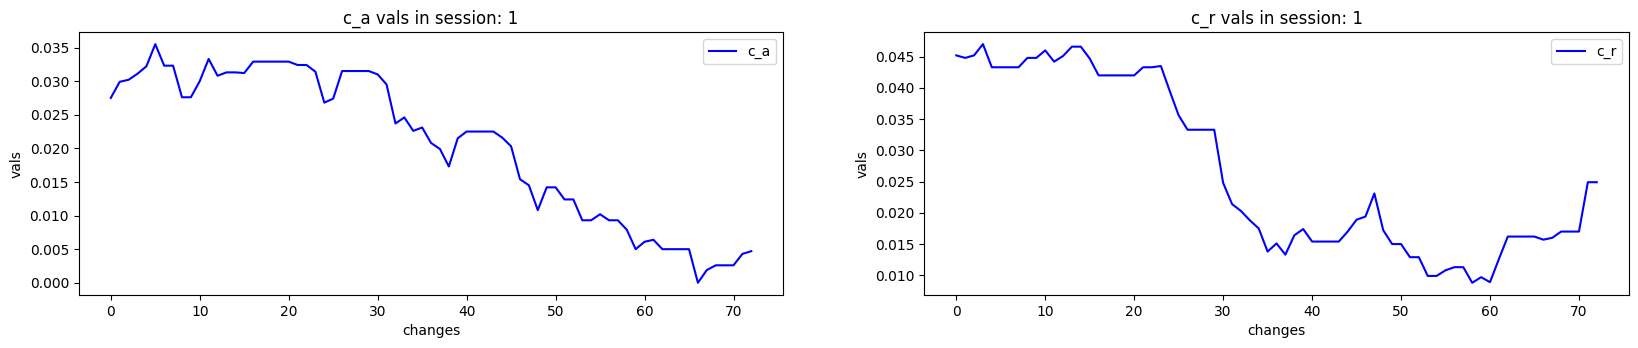

In [13]:
for i in range(len(total_avg_profit_perS)):
    plot_params_pps(total_avg_profit_perS[i], betas[i], momentums[i], c_a[i], c_r[i], initial_margin[i], i+1)

The data is tested for normality using shapiro stats test, and either a one sample t-test or wilcoxen t-test is applied to determine statistical significance. The data here is the average increase in profit for the single zipsh trader within each 30 independant runs. As the output below shows, the data is not normalised, and the significance value is below the threshold of 0.05 suggesting that under the circustances above, the trader does not significantly become more profitable in the market.

In [6]:
test(total_avg_profit_perS)

[99.63145616753937, 105.03949306208752, nan]
normal, using t-test


c:\Users\Radur\OneDrive\Documents\GitHub\ADL-CW\fintech-CW\helper.py:433: RuntimeWarning: invalid value encountered in scalar divide
  pf = (taps[i][j+1] *100) / taps[i][j]


nan

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [91]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [92]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-IEFT-template.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 1448. Limit is 2000 words.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from scipy.stats import mstats
from BSE import market_session
from sklearn import preprocessing

def make_df(path: str):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2', 'err']
    df_profit = df[['avg profit1', 'avg profit2']]
    df_profit.columns = ['SHVR', 'ZIC']
    return df, df_profit

def collect_avg_profit(df):
    _zic = df['ZIC'][len(df)-1]
    _shvr = df['SHVR'][len(df)-1]
    return _zic, _shvr

def plot_performance(n50mean_zic, n500mean_zic, n50mean_shvr, n500mean_shvr):

    fig = plt.figure(figsize=(20, 7.5))
    ax1 = fig.add_subplot(221)
    ax1.plot(n50mean_zic, 'b', n50mean_shvr, 'r')
    ax2 = fig.add_subplot(222)
    ax2.plot(n500mean_zic, 'b', n500mean_shvr, 'r')

    ax1.title.set_text('zic vs shvr 50 sessions')
    ax2.title.set_text('zic vs shvr 500 sessions')

def compare(shvr, zic):
    shvr_w = 0
    zic_w = 0
    for i in range(len(shvr)):
        if shvr[i] - zic[i] > 0:
            shvr_w += 1
        else:
            zic_w += 1
    
    return shvr_w, zic_w

def trader_specs_two(R, n):
    SHVR_num = (n*R)//100
    zic_num = ((100-R)*n)//100
    buyer_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    seller_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    return trader_specs

def run_market_sim(trial_id, no_sessions, R, n, supply_range, demand_range, start_time, end_time, path):
    trader_specs = trader_specs_two(R, n)
    total_avg_zic = []
    total_avg_shvr = []
    
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 60
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                    'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}

        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        _, df_profit = make_df(path)
        _zic, _shvr = collect_avg_profit(df_profit)
        total_avg_shvr.append(_shvr)
        total_avg_zic.append(_zic)
    
    return total_avg_shvr, total_avg_zic

def R_market_run(R, no_sessions, n, supply_range, demand_range, start_time, end_time):
    res = []
    tmp = "n" + str(no_sessions) + "_"
    for r in R:
        trial_id = tmp + str(r)
        path = str(trial_id) + "_avg_balance.csv"
        res.append(run_market_sim(trial_id, no_sessions, r, n, supply_range, demand_range, start_time, end_time, path))

    return res

def plot_wins(res50: list, res500: list):
    shvr_win50 = [0] * 9
    zic_win50 = [0] * 9
    zic_win500 = [0] * 9
    shvr_win500 = [0] * 9
    for i in range(9):
        shvr50 = res50[i][0]
        zic50 = res50[i][1]
        shvr500 = res500[i][0]
        zic500 = res500[i][1]
        for z in range(len(zic500)):
            if shvr500[z] > zic500[z]:
                shvr_win500[i] += 1
                zic_win500[i] = len(zic500) - shvr_win500[i]            
        for j in range(len(zic50)):
            if shvr50[j] > zic50[j]:
                shvr_win50[i] += 1
                zic_win50[i] = len(zic50) - shvr_win50[i]

    fig = plt.figure(figsize=(20, 7.5))
    ax1 = fig.add_subplot(221)
    ax1.plot(shvr_win50, 'b', label='shvr')
    ax1.plot(zic_win50, 'r', label='zic')
    ax1.legend()
    ax2 = fig.add_subplot(222)
    ax2.plot(shvr_win500, 'b', label='shvr')
    ax2.plot(zic_win500, 'r', label='zic')
    ax2.legend()

def collect_pvals_norm(marketoutput: list):
    res = []
    for i in range(len(marketoutput)):
        _, p_shvr = stats.shapiro(marketoutput[i][0])
        _, p_zic = stats.shapiro(marketoutput[i][1])
        p_res_50 = [p_shvr, p_zic]
        res.append(p_res_50)
    return res

def A_B_test(p_val: list, data_: list, a: float = 0.05):
    res = []

    for i in range(len(p_val)):
        if p_val[i][0] < a or p_val[i][1] < a:
            _, pval = stats.mannwhitneyu(data_[i][0], data_[i][1])
            print("n="+ str(len(data_[0][0])) + ", ratio: "+ str((i+1))+ " to "+ str(9-i) + " is NOT normal used NON-parametric test, p val is:", "{:.4f}".format(pval))
            res.append(pval)
        elif p_val[i][0] > a and p_val[i][1] > a:
            _, pval = stats.ttest_ind(data_[i][0], data_[i][1], equal_var=False)
            print("n="+ str(len(data_[0][0])) + ", ratio: "+ str((i+1))+ " to "+ str(9-i)+" is NORMAL used parametric test, p val is:", "{:.4f}".format(pval))
            res.append(pval)
    
    return res

def a_b_c_test(shvr_avg, gvwy_avg, zic_avg, zip_avg, res):
    
    if res[0][0] < 0.05 or res[0][1] < 0.05 or res[0][2] < 0.05 or res[0][3] < 0.05:
        _, p = stats.kruskal(shvr_avg, gvwy_avg, zic_avg, zip_avg)
    else:
        _, p = stats.f_oneway(shvr_avg, gvwy_avg, zic_avg, zip_avg)
    return p

def collect_mean_4(df):
    mean_zic = df['ZIC'][len(df)-1]
    mean_shvr = df['SHVR'][len(df)-1]
    mean_GVWY = df['GVWY'][len(df)-1]
    mean_zip = df['ZIP'][len(df)-1]
    return mean_shvr, mean_GVWY, mean_zic, mean_zip

def df_four(path):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2',
                   'trader3', 'total profit3', 'no. 3', 'avg profit3', 'trader4', 'total profit4', 'no. 4', 'avg profit4', 'err']
    df_profit = df[['avg profit1', 'avg profit2', 'avg profit3', 'avg profit4']]
    df_profit.columns = ['GVWY', 'SHVR', 'ZIC', 'ZIP']
    return df, df_profit    

def run_market_sim_four(trial_id, no_sessions, t, n, supply_range, demand_range, start_time, end_time):
    res = [[] for _ in range(4)]

    seller_spec = [('SHVR', int(t[0]*n/100)), ('GVWY', int(t[1]*n/100)), ('ZIC', int(t[2]*n/100)), ('ZIP', int(t[3]*n/100))]
    buyer_spec = [('SHVR', int(t[0]*n/100)), ('GVWY', int(t[1]*n/100)), ('ZIC', int(t[2]*n/100)), ('ZIP', int(t[3]*n/100))]
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    path = str(trial_id) + "_avg_balance.csv"
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 60
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}
        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        _, df_profit = df_four(path)
        mean_shvr, mean_GVWY, mean_zic, mean_zip = collect_mean_4(df_profit)
        res[0].append(mean_shvr)
        res[1].append(mean_GVWY)
        res[2].append(mean_zic)
        res[3].append(mean_zip)
    
    p = if_norm(res)
    
    result = a_b_c_test(res[0], res[1], res[2], res[3], p)
    

            
    return res, result

def if_norm(res):
    p_vals = []
    _, p_shvr = stats.shapiro(res[0])
    _, p_gvwy = stats.shapiro(res[1])
    _, p_zic = stats.shapiro(res[2])
    _, p_zip = stats.shapiro(res[3])
    p_vals.append([p_shvr, p_gvwy, p_zic, p_zip])

    return p_vals

def find_bigger(pvals: list):
    res = []
    for i, p in enumerate(pvals):
        if p > 0.05:
            res.append(i)
    return res

def plot_performance_same_ratio(res50):
    shvr_w = 0
    gvwy_w = 0
    zic_w = 0
    zip_w = 0
    for i in range(len(res50[0])):
        if res50[0][i] > res50[1][i] and res50[0][i] > res50[2][i] and res50[0][i] > res50[3][i]:
            shvr_w += 1
        elif res50[1][i] > res50[0][i] and res50[1][i] > res50[2][i] and res50[1][i] > res50[3][i]:
            gvwy_w += 1
        elif res50[2][i] > res50[0][i] and res50[2][i] > res50[1][i] and res50[2][i] > res50[3][i]:
            zic_w += 1
        else:
            zip_w+=1
    
    xlabels = ['shvr', 'gvwy', 'zic', 'zip']
    vals = [shvr_w, gvwy_w, zic_w, zip_w]
    col = ['tab:red', 'tab:green', 'tab:blue', 'tab:red']
    fig = plt.figure(figsize=(20, 7.5))
    ax1 = fig.add_subplot(221)
    ax1.plot(res50[0], 'r', label='shvr')
    ax1.plot(res50[1], 'g', label='gvwy')
    ax1.plot(res50[2], 'b', label='zic')
    ax1.plot(res50[3], 'y', label='zip') #res50[1], 'g', res50[2], 'b', res50[3], 'y'
    ax1.set_xlabel('session')
    ax1.set_ylabel('average profit')
    ax1.title.set_text('zic vs zip vs shvr vs gvwy avg profit')
    ax1.legend()
    ax2 = fig.add_subplot(222)
    ax2.bar(xlabels, vals, color=col)
    ax2.set_xlabel("trader")
    ax2.set_ylabel("wins")
    ax2.title.set_text('same ratio, number of wins')

def gather_wins(res):
    gvwy_wins = [0] * 4
    shvr_wins = [0] * 4
    zic_wins = [0] * 4
    zip_wins = [0] * 4

    for i in range(4):
        shvr = res[i][0]
        gvwy = res[i][1]
        zic = res[i][2]
        zip_ = res[i][3]
        for z in range(len(shvr)):
            if shvr[z] > gvwy[z] and shvr[z] > zic[z] and shvr[z] > zip_[z]:
                shvr_wins[i] += 1
            if gvwy[z] > shvr[z] and gvwy[z] > zic[z] and gvwy[z] > zip_[z]:
                gvwy_wins[i] += 1
            if zic[z] > shvr[z] and zic[z] > gvwy[z] and zic[z] > zip_[z]:
                zic_wins[i] += 1
            if zip_[z] > shvr[z] and zip_[z] > zic[z] and zip_[z] > gvwy[z]:
                zip_wins[i] += 1
    return shvr_wins, gvwy_wins, zic_wins, zip_wins

def sub_plot_add(shvrw, gvwyw, zicw, zipw, fig, index, ratio, axID, n):
    ax = "ax"+str(axID)
    ax = fig.add_subplot(index)
    ax.plot(shvrw, 'r', label='shvr')
    ax.plot(gvwyw, 'g', label='gvwy')
    ax.plot(zicw, 'b', label='zic')
    ax.plot(zipw, 'y', label='zip')
    title = 'for ratio ' + str(ratio) +', trader wins per permutation in ' + str(n) + ' sessions'
    ax.title.set_text(title)
    ax.legend()


def plot_wins_4(res1: list, ratio1: list, res2: list, ratio2: list, res3: list, ratio3: list):
    shvr_wins1, gvwy_wins1, zic_wins1, zip_wins1 = gather_wins(res1)
    shvr_wins2, gvwy_wins2, zic_wins2, zip_wins2 = gather_wins(res2)
    shvr_wins3, gvwy_wins3, zic_wins3, zip_wins3 = gather_wins(res3)

    fig1 = plt.figure(figsize=(20, 7))
    
    sub_plot_add(shvr_wins1, gvwy_wins1, zic_wins1, zip_wins1, fig1, 221, ratio1, 1, len(res1[0][0]))
    sub_plot_add(shvr_wins2, gvwy_wins2, zic_wins2, zip_wins2, fig1, 222, ratio2, 2, len(res2[0][0]))
    sub_plot_add(shvr_wins3, gvwy_wins3, zic_wins3, zip_wins3, fig1, 223, ratio3, 3, len(res3[0][0]))



def run_market_sim_D(trial_id, no_sessions, supply_range, demand_range, start_time, end_time, path, path_strat, buyer_spec, seller_spec):
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    total_avg_zipsh = []
    avg_pps_total = []
    total_avg_prof_per_session = []
    hyper_params = [[] for _ in range(5)]
    
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 30
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                    'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True,
                            'dump_avgbals': True, 'dump_tape': False}

        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        df_strats, df_profit = make_df_D(path, path_strat)
        b, m, ca, cr, mb = collect_hyperparams(df_strats)
        hyper_params[0].append(b)
        hyper_params[1].append(m)
        hyper_params[2].append(ca)
        hyper_params[3].append(cr)
        hyper_params[4].append(mb)        
        _, _zipsh, avg_pps, avg_prof_per_sec = collect_avg_profit_D(df_profit)
        total_avg_zipsh.append(_zipsh)
        avg_pps_total.append(avg_pps)
        total_avg_prof_per_session.append(avg_prof_per_sec)
    
    return total_avg_zipsh, avg_pps_total, total_avg_prof_per_session, hyper_params

def make_df_D(path: str, path_strat):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2', 'err']
    df_profit = df[['time', 'avg profit1', 'avg profit2']]
    df_profit.columns = ['time', 'ZIC', 'ZIPSH']

    imap = {1: 'time', 26: 'mBuy', 30: 'beta', 32: 'momentum', 34: 'c_r', 36: 'c_a'}

    df_st = pd.read_csv(path_strat)
    cols = []
    for i in range(38):
        if i in imap:
            cols.append(imap[i])
        else: 
            cols.append('idc')
    df_st.columns = cols
    df_strat = df_st[['time', 'mBuy', 'beta', 'momentum', 'c_r', 'c_a']]

    return df_strat, df_profit

def collect_hyperparams(df):
    beta = []
    momentum = []
    c_r = []
    c_a = []
    mBuy = []
    for i in range(len(df)):
        beta.append(df['beta'][i])
        momentum.append(df['momentum'][i])
        c_r.append(df['c_r'][i])
        c_a.append(df['c_a'][i])
        mBuy.append(df['mBuy'][i])
    
    return beta, momentum, c_a, c_r, mBuy

def collect_avg_profit_D(df):
    average_pps_per_day = []
    prof_per_sec = []
    _zic = df['ZIC'][len(df)-1]
    _zipsh = df['ZIPSH'][len(df)-1]
    _avg_pps = _zipsh/df['time'][len(df)-1]
    n = 1
    for i in range(len(df)):
        if i < 1:
            continue

        if df['time'][i] == df['time'][i-1]:
            continue

        if df['ZIPSH'][i] < df['ZIPSH'][i-1]:
            print("mutation happened")
            continue

        pf = (df['ZIPSH'][i] - df['ZIPSH'][i-1])/(df['time'][i] - df['time'][i-1])
        prof_per_sec.append(pf)

        if df['time'][i] >= 60*60*24*n:
            n+=1
            average_pps_per_day.append((sum(prof_per_sec)/len(prof_per_sec)))
            prof_per_sec = []

    return _zic, _zipsh, _avg_pps, average_pps_per_day

def prof_increase(tvg):
    #tvg total average profit
    total_prof_increase = []
    for i in range(len(tvg)):
        for _ in range(len(tvg[i])):
            prof_increase = (tvg[i][len(tvg[i]-1)]/tvg[i][0]) * 100
            total_prof_increase.append(prof_increase)
    return total_prof_increase

def plot_params_pps(tpi, betas, mom, c_a, c_r, mBuy, n):
    #tpi = total_avg_profit_perS[i]
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(221)
    ax1.plot(tpi, 'r', label='zipsh') #res50[1], 'g', res50[2], 'b', res50[3], 'y'
    ax1.set_xlabel('changes')
    ax1.set_ylabel('average pps')
    ax1.title.set_text('avg pps for zipsh in the session ' + str(n))
    ax1.legend()
    ax2 = fig.add_subplot(222)
    ax2.plot(betas, 'b', label='beta')
    ax2.set_xlabel('changes')
    ax2.set_ylabel('vals')
    ax2.title.set_text('beta vals in session: ' + str(n))
    ax2.legend()
    ax3 = fig.add_subplot(223)
    ax3.plot(mom, 'b', label='momentum')
    ax3.set_xlabel('changes')
    ax3.set_ylabel('vals')
    ax3.title.set_text('momentum vals in session: ' + str(n))
    ax3.legend()
    ax4 = fig.add_subplot(224)
    ax4.plot(mBuy, 'b', label='margin buy')
    ax4.set_xlabel('changes')
    ax4.set_ylabel('vals')
    ax4.title.set_text('margin buy vals in session: ' + str(n))
    ax4.legend()
    fig2 = plt.figure(figsize=(20, 7.5))
    ax = fig2.add_subplot(221)
    ax.plot(c_a, 'b', label='c_a')
    ax.set_xlabel('changes')
    ax.set_ylabel('vals')
    ax.title.set_text('c_a vals in session: ' + str(n))
    ax.legend()
    ax5 = fig2.add_subplot(222)
    ax5.plot(c_r, 'b', label='c_r')
    ax5.set_xlabel('changes')
    ax5.set_ylabel('vals')
    ax5.title.set_text('c_r vals in session: ' + str(n))
    ax5.legend()


def test(taps):
    avg_total = []
    for i in range(len(taps)):
        avg_end_eachD = []
        for j in range(len(taps[i])-1):
            pf = (taps[i][j+1] *100) / taps[i][j]
            if pf <=0:
                avg_end_eachD.append(0)
            else:
                avg_end_eachD.append(pf)
        avg_total.append(np.mean(avg_end_eachD))
    print(avg_total)

    _, p = stats.shapiro(avg_total)

    if p < 0.05:
        print("not normal, using wilcoxen")
        _, pval = stats.wilcoxon(avg_total)
        return pval
    else:
        print("normal, using t-test")
        _, pval = stats.ttest_1samp(avg_total, np.mean(0.05))
        return pval